# 模型选择、欠拟合和过拟合

通过多项式拟合来交互地探索这些概念

In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

使用以下三阶多项式来生成训练和测试数据的标签：
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2)$$

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

features = np.random.normal(size=(n_train + n_test, 1))
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1, -1))
for i in range(max_degree):
    poly_features[:, i] /= math.gamma(i + 1)
labels = np.dot(poly_features, true_w)
labels += np.random.normal(scale=0.1, size=labels.shape)

看一下前2个样本

In [4]:
true_w, features, poly_features, labels = [
    torch.tensor(x, dtype=torch.float32)
    for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[0.8370],
         [1.5821]]),
 tensor([[1.0000e+00, 8.3696e-01, 3.5025e-01, 9.7714e-02, 2.0446e-02, 3.4224e-03,
          4.7740e-04, 5.7080e-05, 5.9717e-06, 5.5534e-07, 4.6480e-08, 3.5365e-09,
          2.4666e-10, 1.5880e-11, 9.4935e-13, 5.2971e-14, 2.7709e-15, 1.3642e-16,
          6.3432e-18, 2.7942e-19],
         [1.0000e+00, 1.5821e+00, 1.2515e+00, 6.5998e-01, 2.6103e-01, 8.2595e-02,
          2.1779e-02, 4.9222e-03, 9.7340e-04, 1.7111e-04, 2.7071e-05, 3.8935e-06,
          5.1332e-07, 6.2469e-08, 7.0594e-09, 7.4456e-10, 7.3622e-11, 6.8515e-12,
          6.0220e-13, 5.0143e-14]]),
 tensor([5.5372, 6.4627]))

实现一个函数来评估模型在给定数据集上的损失

In [5]:
def evaluate_loss(net, data_iter, loss):  
    """评估给定数据集上模型的损失。"""
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

定义训练函数

In [6]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(
                net, train_iter, loss), evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

三阶多项式函数拟合(正态)

weight: [[ 5.022382   1.2501193 -3.4170845  5.5394874]]


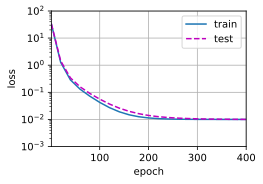

In [7]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

线性函数拟合(欠拟合)

weight: [[2.8986177 4.651503 ]]


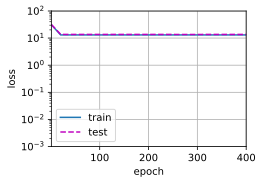

In [8]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

高阶多项式函数拟合(过拟合)

weight: [[ 5.0116901e+00  1.3101708e+00 -3.3885837e+00  5.2435675e+00
  -7.5802460e-02  8.3919930e-01  3.2364017e-01 -1.7154990e-01
  -1.3703778e-01 -4.1064180e-02 -1.2828453e-03  2.0206796e-01
   2.1970727e-02  3.0206902e-02  6.4388968e-02  8.8640936e-02
   1.7308978e-02  6.9872744e-02  5.6645162e-02 -8.5549526e-02]]


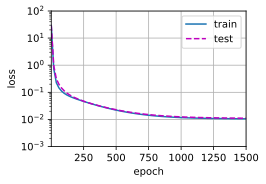

In [9]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)